In [ ]:
from skimage.io import imread
import os
import json
from tqdm.notebook import tqdm
from tqdm.autonotebook import tqdm, trange
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from matplotlib import rcParams

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


We use the dataset of images by the [link](#https://disk.yandex.ru/d/lSkJ25yjP0t8tQ)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Sun May  1 20:29:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def show_img_with_mask(img, mask, figsize=(14, 8)):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img)
    ax2.imshow(mask)
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

To make sure that everything is correct, we will draw several images

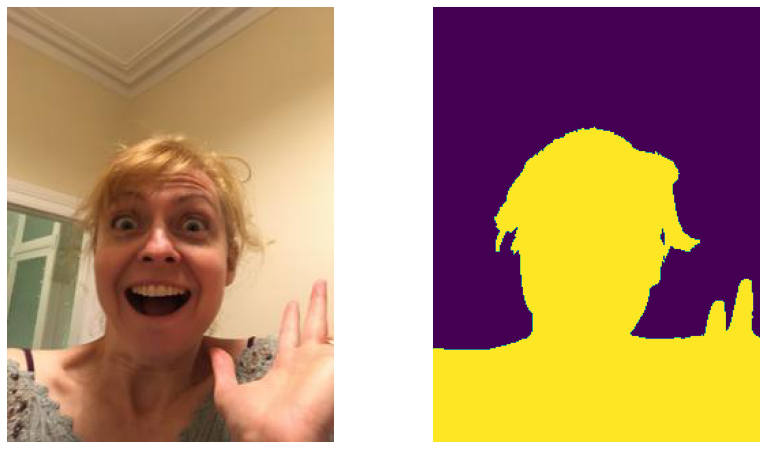

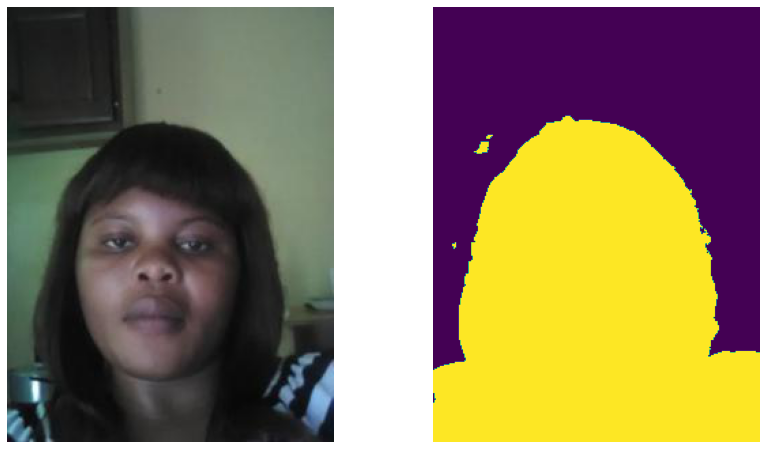

In [ ]:
path_train = '/content/drive/MyDrive/Segmentation/train'
path_valid = '/content/drive/MyDrive/Segmentation/valid'
path_test = '/content/drive/MyDrive/Segmentation/test'

images_train = os.listdir(path_train)
images_test = os.listdir(path_test)
images_valid = os.listdir(path_valid)

ind_train = np.random.choice(images_train).split(".")[0]
ind_valid = np.random.choice(images_valid).split(".")[0]

img_train = np.array(Image.open(f"{path_train}/{ind_train}.jpg"))
mask_train = np.array(Image.open(f"{path_train}_mask/{ind_train}.png"))
show_img_with_mask(img_train, mask_train)

img_valid = np.array(Image.open(f"{path_valid}/{ind_valid}.jpg"))
mask_valid = np.array(Image.open(f"{path_valid}_mask/{ind_valid}.png"))
show_img_with_mask(img_valid, mask_valid)

In [ ]:
print(len(images_train))
print(len(images_valid))
print(len(images_test))

1315
145
100


In [ ]:
X_train = []
X_valid = []
X_test = []

y_train = []
y_valid = []

for i in tqdm(range(len(images_train))):
    ind_train = images_train[i].split(".")[0]
    X_train.append(np.array(Image.open(f"{path_train}/{ind_train}.jpg")))
    y_train.append(np.array(Image.open(f"{path_train}_mask/{ind_train}.png")))

for i in tqdm(range(len(images_valid))):
    ind_valid = images_valid[i].split(".")[0]
    X_valid.append(np.array(Image.open(f"{path_valid}/{ind_valid}.jpg")))
    y_valid.append(np.array(Image.open(f"{path_valid}_mask/{ind_valid}.png")))

for i in tqdm(range(len(images_test))):
    ind_test = images_test[i].split(".")[0]
    X_test.append(np.array(Image.open(f"{path_test}/{ind_test}.jpg")))

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


In [ ]:
X_train = torch.from_numpy(np.array(X_train)).float()
X_valid = torch.from_numpy(np.array(X_valid)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
y_train = torch.from_numpy(np.array(y_train)).float()
y_valid = torch.from_numpy(np.array(y_valid)).float()

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader

def load_data(X, y, batch_size):

    #transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    dataset = torch.utils.data.DataLoader(list(zip(X, y/255)), batch_size=batch_size, shuffle=True)
    return dataset

In [ ]:
data_train = load_data(X_train, y_train, 10)
data_valid = load_data(X_valid, y_valid, 10)

#### Augmentation

In [ ]:
import random
import torchvision
from albumentations import VerticalFlip, HorizontalFlip, RandomSizedCrop, Rotate,Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise, RandomBrightnessContrast

def Augment(X, y):

    if random.random() > 0.5:
        X = torchvision.transforms.functional.vflip(X)
        y = torchvision.transforms.functional.vflip(y)

    r = random.random()
    degs = [-20, 20, -15, 15, -10, 10, -5, 5]
    if 0.05 <= r < 0.7:
        deg = random.choice(degs)
        X = torchvision.transforms.functional.rotate(X, deg, expand=False)
        y = torchvision.transforms.functional.rotate(y, deg, expand=False)

    return X, y

In [ ]:
X_aug, y_aug = Augment(X_train[0:10], y_train[0:10])

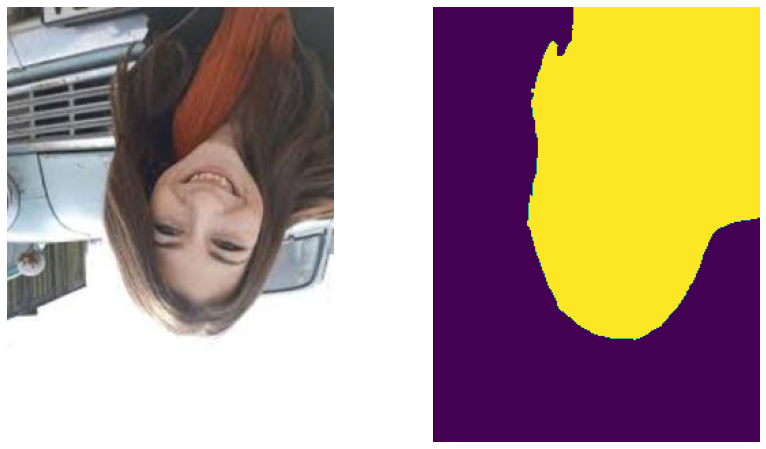

In [ ]:
num_aug = 0
show_img_with_mask(X_aug[num_aug].permute(1,2,0).int(), y_aug[num_aug].int())

## Метрика

In this section, it is proposed to use the following metric for quality assessment:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the main truth mask, whereas the union (A ∪ B) simply consists of all pixels found in either the prediction mask or the target mask.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

## Loss functions

In [ ]:
def dice_loss(y_real, y_pred):
    eps = 1
    num = (2*y_real*y_pred).sum()
    den =  y_real.sum() + y_pred.sum()
    res = (num + eps)/(den + eps)
    return 1-res 

## U-Net

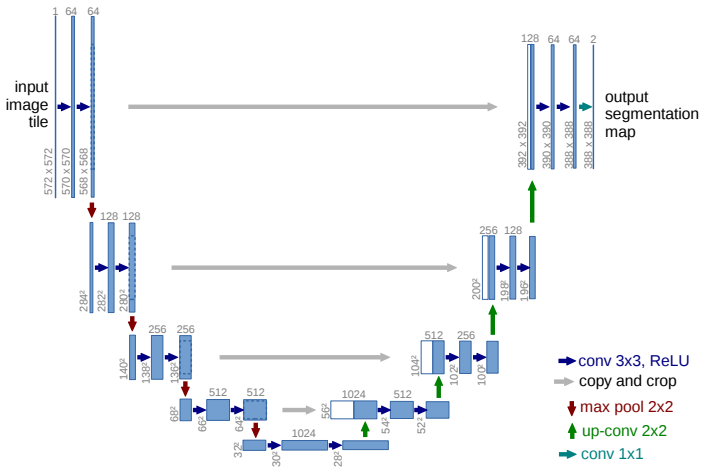

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), # b_sx3x320x240 -> b_sx64x320x240
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # b_sx64x320x240 -> b_sx64x320x240
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # b_sx64x320x240 -> b_sx64x160x120

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # b_sx64x160x120 -> b_sx128x160x120
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # b_sx128x160x120 -> b_sx128x160x120
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # b_sx128x160x120 -> b_sx128x80x60

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # b_sx128x80x60 -> b_sx256x80x60
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # b_sx256x80x60 -> b_sx256x80x60
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # b_sx256x80x60 -> b_sx256x80x60
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # b_sx256x80x60 -> b_sx256x40x30

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), # b_sx256x40x30 -> b_sx512x40x30
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x40x30 -> b_sx512x40x30
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x40x30 -> b_sx512x40x30
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # b_sx512x40x30 -> b_sx512x20x15

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x20x15 -> b_sx512x20x15
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x20x15 -> b_sx512x20x15
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x20x15 -> b_sx512x20x15
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x20x15 -> b_sx512x20x15
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # b_sx512x20x15 -> b_sx512x40x30

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1), # b_sx1024x40x30 -> b_sx512x40x30
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # b_sx512x40x30 -> b_sx512x40x30
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), # b_sx512x40x30 -> b_sx256x40x30
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # b_sx256x40x30 -> b_sx256x40x30
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # b_sx256x40x30 -> b_sx256x80x60

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), # b_sx512x80x60 -> b_sx256x80x60
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), # b_sx256x80x60 -> b_sx256x80x60
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # b_sx256x80x60 -> b_sx128x80x60
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # b_sx128x80x60 -> b_sx128x80x60
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # b_sx128x80x60 -> b_sx128x160x120

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # b_sx256x160x120 -> b_sx128x160x120
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # b_sx128x160x120 -> b_sx128x160x120
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # b_sx128x160x120 -> b_sx64x160x120
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # b_sx64x160x120 -> b_sx64x160x120
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # b_sx64x160x120 -> b_sx64x320x240

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # b_sx128x320x240 -> b_sx64x320x240
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # b_sx64x320x240 -> b_sx64x320x240
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # b_sx64x320x240 -> b_sx64x320x240
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1), # b_sx64x320x240 -> b_sx1x320x240
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1), # b_sx64x320x240 -> b_sx1x320x240
            nn.BatchNorm2d(1)
        )

        self.drop1 = nn.Dropout2d(0.2)
        self.drop2 = nn.Dropout2d(0.2)

    def forward(self, x):

        # encoder
        x = self.enc_conv0(x) # b_sx64x160x120
        p0 = self.pool0(x) # b_sx64x160x120
        e0 = self.enc_conv1(p0) # b_sx128x160x120
        p1 = self.pool1(e0) # b_sx128x80x60
        e1 = self.enc_conv2(p1) # b_sx256x80x60
        p2 = self.pool2(e1) # b_sx256x40x30
        e2 = self.enc_conv3(p2) # b_sx512x40x30
        p3 = self.pool3(e2) # b_sx512x20x15
        p3 = self.drop1(p3)
        
        # bottleneck
        b = self.bottleneck_conv(p3) # b_sx512x20x15
        b = self.drop2(b)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b),e2], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e1], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e0], dim=1))
        d3 =  self.dec_conv3(torch.cat([self.upsample3(d2), x], dim=1))
        
        return torch.sigmoid(d3)

## Train

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        #scheduler.step()

        tic = time()
        print('Epoch %d/%d' % (epoch+1, epochs))

        loss_train = 0
        train_acc = 0
        loss_val = 0
        acc_val = 0

        model.train()  # train mode

        for data in tqdm(data_tr):
            X_batch = data[0]
            Y_batch = data[1]
            X_batch, Y_batch = Augment(X_batch, Y_batch)
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)

            loss = loss_fn(Y_batch, Y_pred.permute(1,0,2,3)[0])
            loss_train += loss.item()
            loss.backward()
            opt.step()

            train_acc += torch.mean(iou_pytorch(torch.round(model(X_batch)), Y_batch)).detach().cpu().numpy().item()

            #del X_batch, Y_batch, loss
            #torch.cuda.empty_cache()  

        toc = time()
        print('loss = ', loss_train/len(data_tr))
        print('accuracy = ', train_acc/len(data_tr))
        with torch.no_grad():
            model.eval()
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)

            Y_hat = model(X_val).detach()
            loss_val = loss_fn(Y_val, Y_hat.permute(1,0,2,3)[0]).item()
        
            acc_val = torch.mean(iou_pytorch(torch.round(Y_hat), Y_val)).detach().cpu().numpy().item()

            if acc_val > best_acc:
                best_acc = acc_val
                best_model_wts = model.state_dict()

            history.append((loss_train/len(data_tr), train_acc/len(data_tr), loss_val, acc_val))

            X_val = X_val.to('cpu')
            Y_val = Y_val.to('cpu')
            Y_hat = Y_hat.to('cpu')

            model.load_state_dict(best_model_wts)

    return model, history

## Inference

In [ ]:
def predict(model, data):
    with torch.no_grad():
      model.eval()  # testing mode
      Y_pred = torch.round(model(data.to(device)))

    return np.array(Y_pred.to('cpu'))

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)

        Y_pred = torch.round(model(X_batch))

        scores += torch.mean(metric(Y_pred, Y_label))

        del X_batch, Y_label, Y_pred

    return (scores/len(data)).detach().cpu().numpy().item()

In [ ]:
print('memory is busy:', torch.cuda.memory_allocated(device)/1024/1024/1024, 'Gb')

памяти занято: 0.48300790786743164 Gb


In [ ]:
model = UNet().to(device)

In [ ]:
max_epochs = 5
optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
#lr_sch = lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)
#model, history = train(model, optim, lr_sch, bce_loss, max_epochs, data_train, data_valid)
model, history = train(model, optim, dice_loss, max_epochs, data_train, data_valid)

Epoch 1/5


100%|██████████| 132/132 [03:00<00:00,  1.37s/it]


loss =  0.10943659191781824
accuracy =  0.6839394163001667
Epoch 2/5


100%|██████████| 132/132 [02:59<00:00,  1.36s/it]


loss =  0.10852003503929485
accuracy =  0.6887878917834975
Epoch 3/5


100%|██████████| 132/132 [02:59<00:00,  1.36s/it]


loss =  0.10658477201606288
accuracy =  0.6938636555816188
Epoch 4/5


100%|██████████| 132/132 [02:58<00:00,  1.36s/it]


loss =  0.1034921317389517
accuracy =  0.7007575969804417
Epoch 5/5


100%|██████████| 132/132 [02:59<00:00,  1.36s/it]


loss =  0.10563608100920012
accuracy =  0.6956818417617769


In [ ]:
score_model(model, iou_pytorch, data_valid)

0.6780000329017639

In [ ]:
loss1, acc1, val_loss1, val_acc1 = zip(*history)

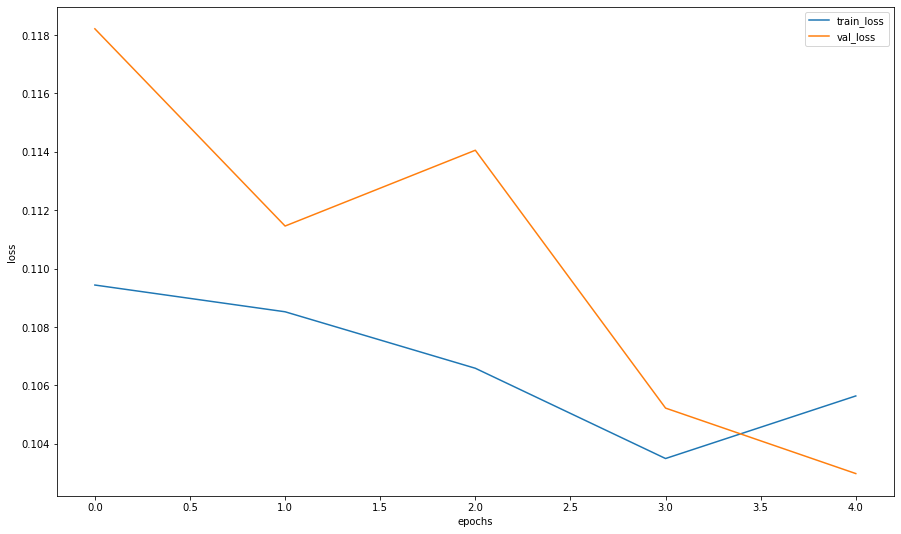

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss1, label="train_loss")
plt.plot(val_loss1, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

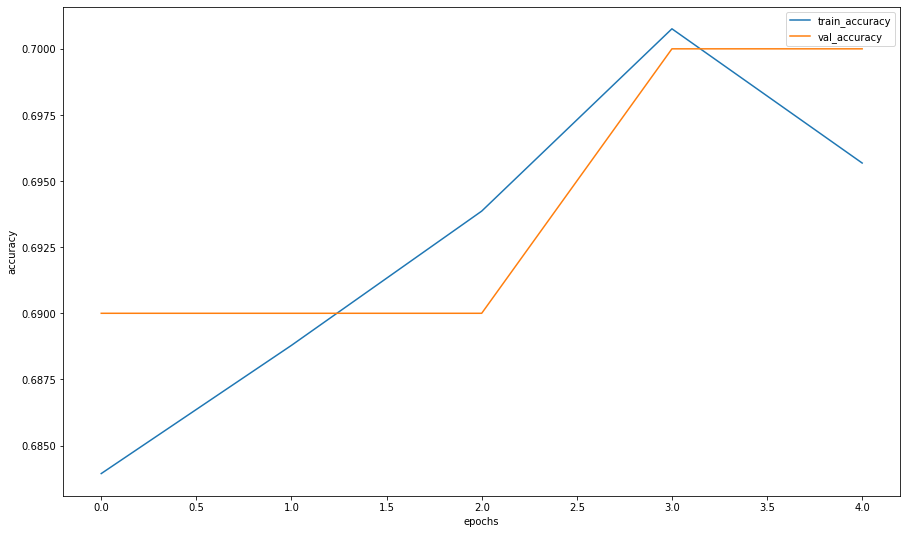

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc1, label="train_accuracy")
plt.plot(val_acc1, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Save the model

In [ ]:
PATH = '/content/drive/MyDrive/Segmentation/model.csv'
torch.save(model.state_dict(), PATH)

Let's test the model on test data

In [ ]:
y_test_pred = predict(model, X_test[0:10])

In [ ]:
num_test = 1

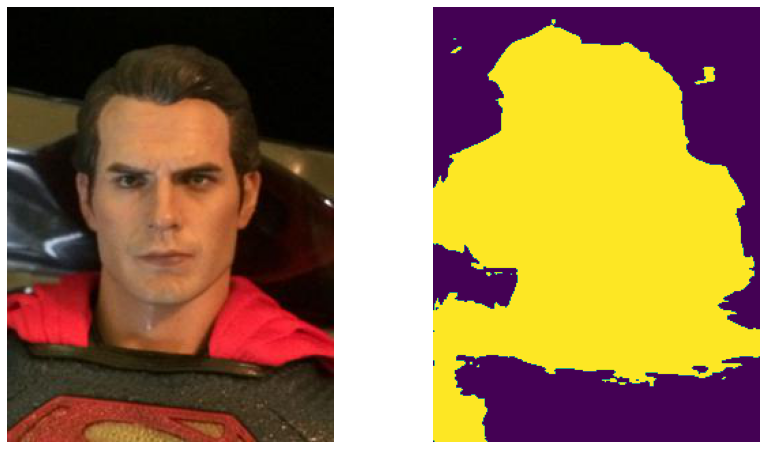

In [ ]:
show_img_with_mask(X_test[num_test].permute(1,2,0).detach().numpy().astype(int), y_test_pred[num_test][0])

Let's check the model on validation data

In [ ]:
y_valid_pred = predict(model, X_valid[0:10])

In [ ]:
num_valid = 2

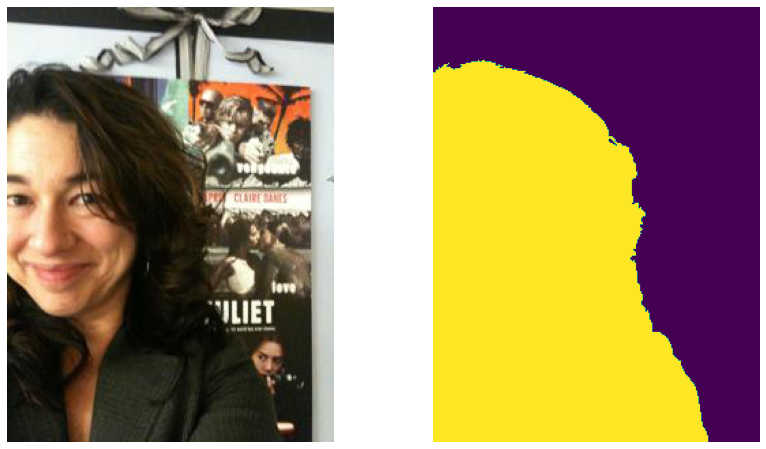

In [ ]:
show_img_with_mask(X_valid[num_valid].permute(1,2,0).detach().numpy().astype(int), y_valid[num_valid])

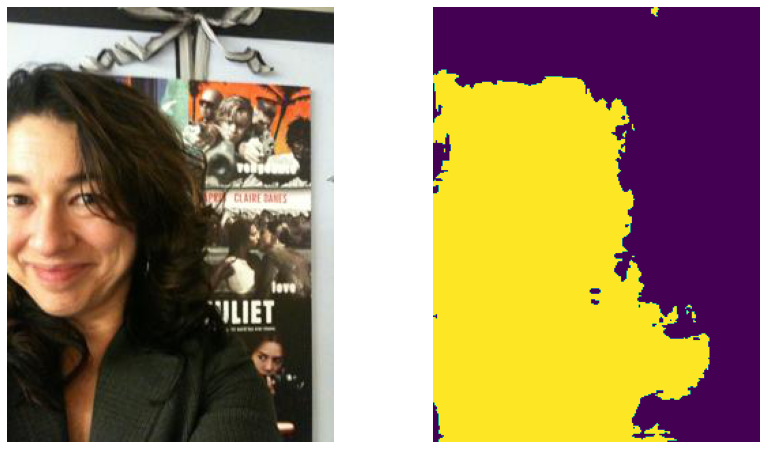

In [ ]:
show_img_with_mask(X_valid[num_valid].permute(1,2,0).detach().numpy().astype(int), y_valid_pred[num_valid][0])

Let's test the model on the training data

In [ ]:
y_train_pred = predict(model, X_train[0:10])

In [ ]:
num_train = 1

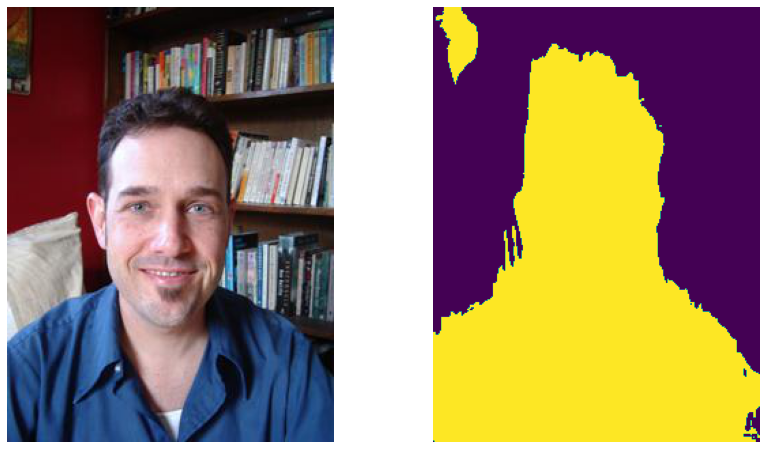

In [ ]:
show_img_with_mask(X_train[num_train].permute(1,2,0).detach().numpy().astype(int), y_train_pred[num_train][0])

## Saving results

Generates html file and saves it.

In [ ]:
import os
import numpy as np

from glob import glob
from PIL import Image
from datetime import datetime

def generate_html(path_to_data):

    html = "\n".join(["<!doctype html>", "<html>", "<head>",
                      "<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>",
                      "<title>Визуализация результатов</title>", "</head>", "<body>",
                      "<table cellspacing='0' cellpadding='5'>"]) + "\n"
    paths_to_imgs = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_img.jpg")])
    paths_to_masks = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_pred_mask.png")])
    paths_to_crops = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_crop.png")])
    for ind, (path_to_img, path_to_mask, path_to_crop) in enumerate(zip(paths_to_imgs,
                                                                        paths_to_masks,
                                                                        paths_to_crops)):
        if not ind % 2:
            html += "<tr>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_img}'"
        html += "alt='Something went wrong.'"
        html += f"height='320' title='Original image:\n{path_to_img}'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_mask}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Predicted mask'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_crop}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Cropped img according\npredicted mask'></td>\n"
        if not ind % 2:
            html += "<td width='100'></td>\n"
        else:
            html += "</tr>\n"
    date = datetime.today().strftime("%Y-%m-%d-%H.%M.%S")
    html += f"</table>\n<i>The page was generated at {date}</i></body>\n</html>"
    filename = os.path.basename(path_to_data) + ".html"
    path_to_save = os.path.dirname(path_to_data)
    with open(f"{path_to_save}/{filename}", "w") as f:
        f.write(html)

    return html


def get_html(paths_to_imgs, pred_masks, path_to_save="results/test"):

    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

    html = generate_html(path_to_save)

    return html

This function returns the encoded mask as a string.

In [ ]:
def encode_rle(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)


def decode_rle(rle_mask, shape=(320, 240)):

    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1

    return img.reshape(shape)

In [ ]:
X_test.shape

torch.Size([100, 3, 320, 240])

In [ ]:
mask_test = []
for i in range(10):
    y_test_mask = predict(model, X_test[i*10:i*10+10])
    for j in range(10):
        mask_test.append(y_test_mask[j][0])

In [ ]:
rle_mask_test = []
for i in range(len(mask_test)):
    rle_mask_test.append(encode_rle(mask_test[i]))

In [ ]:
names_test = []
names_test_sort = []
for i in range(len(rle_mask_test)):
    names_test.append(images_test[i].split(".")[0])
    names_test_sort.append(str(1460+i))

In [ ]:
dict_rle_mask_test = {k:v for k, v in zip(names_test, rle_mask_test)}
rle_mask_sort_test = []
for i in range(len(rle_mask_test)):
    rle_mask_sort_test.append(dict_rle_mask_test[names_test_sort[i]])

In [ ]:
import pandas as pd
df_test = pd.DataFrame()
df_test['id'] = names_test_sort
df_test['rle_mask'] = rle_mask_sort_test
df_test.to_csv('/content/drive/MyDrive/Segmentation/pred_test_template.csv', index=False)

In [ ]:
X_valid.shape

torch.Size([145, 3, 320, 240])

In [ ]:
mask_valid = []
for i in range(29):
    y_valid_mask = predict(model, X_valid[i*5:i*5+5])
    for j in range(5):
        mask_valid.append(y_valid_mask[j][0])

In [ ]:
rle_mask = []
for i in range(len(mask_valid)):
    rle_mask.append(encode_rle(mask_valid[i]))

In [ ]:
names_valid = []
names_valid_sort = []
for i in range(len(rle_mask)):
    names_valid.append(images_valid[i].split(".")[0])
    names_valid_sort.append(str(1315+i))

In [ ]:
dict_rle_mask = {k:v for k, v in zip(names_valid, rle_mask)}
rle_mask_sort = []
for i in range(len(rle_mask)):
    rle_mask_sort.append(dict_rle_mask[names_valid_sort[i]])

In [ ]:
import pandas as pd
df_valid = pd.DataFrame()
df_valid['id'] = names_valid_sort
df_valid['rle_mask'] = rle_mask_sort
df_valid.to_csv('/content/drive/MyDrive/Segmentation/pred_valid_template.csv', index=False)

Let's save the masks of the test images

In [ ]:
for i in range(len(mask_test)):
    im = Image.fromarray((mask_test[i]*255).astype(np.uint8))
    im.save('/content/drive/MyDrive/Segmentation/test_mask/'+names_test[i]+'.png')

In [ ]:
#paths_to_imgs = sorted(glob("data/valid/*"))
paths_to_imgs = sorted(glob('/content/drive/MyDrive/Segmentation/test/*'))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob('/content/drive/MyDrive/Segmentation/test_mask/*'))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save='/content/drive/MyDrive/Segmentation/results/example')